# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [28]:
import csv

import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

import torch

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_filepath = '/kaggle/input/clef2025-checkthat/data/english/train_en.tsv'
test_filepath = '/kaggle/input/clef2025-checkthat/data/english/dev_test_en.tsv'

In [4]:
train_data = pd.read_csv(train_filepath, sep='\t', quoting=csv.QUOTE_NONE)
test_data = pd.read_csv(test_filepath, sep='\t', quoting=csv.QUOTE_NONE)

In [5]:
train_data.label.value_counts(), test_data.label.value_counts()

(label
 OBJ     532
 SUBJ    298
 Name: count, dtype: int64,
 label
 OBJ     362
 SUBJ    122
 Name: count, dtype: int64)

Legend:
* Objective -> 0
* Subjective -> 1

In [6]:
train_data['label'] = train_data['label'].apply(lambda x: 1 if x == 'SUBJ' else 0)
test_data['label'] = test_data['label'].apply(lambda x: 1 if x == 'SUBJ' else 0)

In [7]:
notebook_login()

# Baseline Model

In [ ]:
vect = SentenceTransformer("all-mpnet-base-v2")

In [ ]:
model = LogisticRegression(class_weight="balanced", random_state=SEED)
model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)

In [ ]:
predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

In [ ]:
pred_df = pd.DataFrame()
pred_df['sentence_id'] = test_data['sentence_id']
pred_df['label'] = predictions

In [ ]:
def evaluate_model(gold_values, predicted_values):
    acc = accuracy_score(gold_values, predicted_values)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                               zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                               zero_division=0)
    #roc_auc = roc_auc_score(gold_values, predicted_probabilities)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc,
        #'roc_auc': roc_auc
    }

In [ ]:
evaluate_model(gold_values=test_data.label.values, predicted_values=predictions)

# Twitter RoBERTa-base 2022 154M

In [ ]:
model_card = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'OBJ', 1: 'SUBJ'}, label2id={'OBJ': 0, 'SUBJ': 1})

In [ ]:
def preprocess_text(texts):
    return tokenizer(texts['sentence'])

In [ ]:
train_dl = Dataset.from_pandas(train_data)
test_dl = Dataset.from_pandas(test_data)

In [ ]:
train_dl = train_dl.map(preprocess_text, batched=True)
test_dl = test_dl.map(preprocess_text, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir=f'model',                 
    learning_rate=5e-6,
    per_device_train_batch_size=16,         
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-4,
    eval_strategy="epoch",       
    save_strategy="no",           
    #save_safetensors=True,
    #load_best_model_at_end=True,
    report_to='none',
    seed=SEED,
    data_seed=SEED
)

In [ ]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.get('logits')
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

In [ ]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1-score" : f1, "Accuracy" : acc}

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=test_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [ ]:
trainer.train()

# Emotions

In [9]:
model_card = "arpanghoshal/EmoRoBERTa"
tokenizer = RobertaTokenizerFast.from_pretrained(model_card)
model = TFRobertaForSequenceClassification.from_pretrained(model_card)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [10]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


In [15]:
# Example
emotion_labels = emotion(["Thanks for using it."])
emotion_labels

[{'label': 'gratitude', 'score': 0.9964383840560913}]

In [ ]:
emotion_df = pd.DataFrame(columns=['emotion', 'confidence'])

for sentence in tqdm(train_data['sentence']):
    result = emotion(sentence)[0]
    emotion_df.loc[len(emotion_df)] = [result['label'], result['score']]

In [40]:
train_data_augmented = pd.concat([train_data, emotion_df], axis=1)
train_data_augmented.head()

,sentence_id,sentence,label,solved_conflict,emotion,confidence
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,1,True,realization,0.370921
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,0,False,optimism,0.990538
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,0,False,annoyance,0.946737
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,0,False,surprise,0.861293
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",1,False,neutral,0.996816


In [41]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

<Axes: ylabel='emotion'>

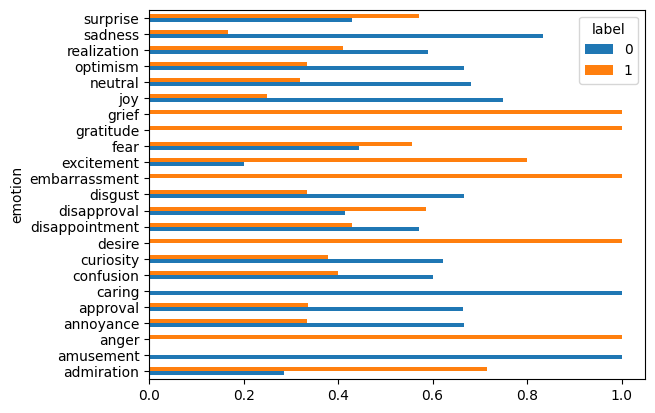

In [62]:
train_data_augmented.groupby('emotion')['label'].value_counts(normalize=True).unstack().plot(kind='barh')